In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import copy
import traceback
import pickle

from matplotlib.colors import LogNorm
from time import sleep
from IPython.display import clear_output
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score

from anisotropy import run_SEPevent

SOLO_SECTORS = ["sun", "asun", "north", "south"]
WIND_SECTORS = [f"P{i}" for i in range(8)]

SOLO_START = dt.datetime(2020, 11, 2)       # first day of available data from SOLO mission
SOLO_END = dt.datetime(2025, 5, 31)

In [ ]:
def get_sectors(sc):
    if sc.lower() == "solo":
        return SOLO_SECTORS

    elif sc.lower() == "wind":
        return WIND_SECTORS

def convert_to_bool_coverage(cov, sc, bin_width_deg=1):
    directions = get_sectors(sc)
    
    X, Y = np.meshgrid(cov.index.values, np.linspace(0, 180, int(180 / bin_width_deg)), indexing="ij")
    cov_arr = np.zeros_like(Y, dtype=np.bool_)

    for direction in directions:
        dataf = cov[direction].mask(cov[direction].isna(), -1)     # replace missing values with -1 to exclude from comparison in the loop
        for index, data in dataf.reset_index().iterrows():
            covered = np.ma.masked_inside(Y[index], data["min"], data["max"])
            cov_arr[index] = cov_arr[index] | covered.mask

    return X, Y, cov_arr

def coverage_overlap(cov1, cov2):   # TODO handle mismatch (remove from coverage with higher amount of timestamps) (this is due to timestamp-based indexing)
    return cov1 & cov2

def intensity_histogram(sc, I_data, coverage):
    """
    Code partly adapted from SOLER anisotropy tools SEPEvent.overview_plot() method (maintained by Jan Gieseler)
    https://github.com/soler-he/sep_tools/tree/main/anisotropy commit 7567a98
    """ 
    intensity = copy.copy(I_data)
    sectors = get_sectors(sc)

    X, Y = np.meshgrid(coverage.index.values, np.arange(180)+1)
    hist = np.zeros(np.shape(X))
    hist_counts = np.zeros(np.shape(X))

    # Extract flux wherever the coverage is finite, 
    # fill with those values between the min and max coverage, 
    # and sum every sector's histogram together. 
    # Could probably be written better.
    for i, direction in enumerate(sectors):
        intensity_per_sector = intensity[:,i]
        cov_arr = coverage[direction].to_numpy()
        cov_finite = coverage[direction].notna().to_numpy()
        av_flux = np.where(cov_finite[:,1], intensity_per_sector, np.nan)  
        new_hist = np.where(((Y > cov_arr[:,0]) & (Y < cov_arr[:,2])), av_flux, 0)
        hist = hist + new_hist    
        hist_counts = hist_counts + np.where(new_hist > 0, 1, 0)   # Overlapping bins are calculated as averages

    hist = hist / hist_counts
    hist = np.where(hist > 0, hist, np.nan)

    return hist

def load_random_file(path):
    r_file = np.random.choice(os.listdir(path)).tolist()
    return np.load(path + os.sep + r_file)


def load_wind_event(df, *args, remove_peaks=False, n_lim=2, **kwargs):
    wind_event = run_SEPevent(*args, **kwargs)
    if remove_peaks:
        wind_event.wind_peak_removal(n_lim=n_lim)
    return wind_event


In [ ]:
# TODO 2.12. check for empty data files

from solo_epd_loader import epd_load

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from IPython.display import clear_output
import sys
import logging
filehandler = logging.FileHandler(filename="solo_cov.log", encoding="utf-8")
streamhandler = logging.StreamHandler(sys.stdout)
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S', handlers=[filehandler, streamhandler], force=True)

SOLO_SECTORS = ["sun", "asun", "north", "south"]
WIND_SECTORS = [f"P{i}" for i in range(8)]

SOLO_START = dt.datetime(2020, 11, 2)
SOLO_END = dt.datetime(2025, 5, 31)

def get_sectors(sc):
    if sc.lower() == "solo":
        return SOLO_SECTORS

    elif sc.lower() == "wind":
        return WIND_SECTORS

def convert_to_bool_coverage(cov, sc, bin_width_deg=1):
    directions = get_sectors(sc)
    
    X, Y = np.meshgrid(cov.index.values, np.linspace(0, 180, int(180 / bin_width_deg)), indexing="ij")
    cov_arr = np.zeros_like(Y, dtype=np.bool_)

    for direction in directions:
        dataf = cov[direction].mask(cov[direction].isna(), -1)     # replace missing values with -1 to exclude from comparison in the loop
        for index, data in dataf.reset_index().iterrows():
            covered = np.ma.masked_inside(Y[index], data["min"], data["max"])
            cov_arr[index] = cov_arr[index] | covered.mask

    return X, Y, cov_arr


if __name__ == "__main__":
    sc = "solo"
    data_path = f"{os.getcwd()}{os.sep}data"
    max_days = (SOLO_END - SOLO_START).days

    try:
        start = int(sys.argv[1])
    except (IndexError, ValueError):
        start = 0
    logging.info(f"Run start: {start}")

    
    for i in range(start, max_days):
        logging.info(f"Day {i}")
        save_path = os.getcwd() + os.sep + "coverages_" + os.sep + sc
        os.makedirs(save_path, exist_ok=True)
        date = SOLO_START + dt.timedelta(days=i)
        logging.info(f"Forming SolO coverages from date {date}")
        try:
            df, df_rtn, df_hci, energies_dict, metadata_dict = epd_load("ept", startdate=date, 
                                                                        level="l3", autodownload=True,
                                                                        path=data_path, pos_timestamp="start")

            if (len(df.index) // 60) < 12:
                logging.info(f"Day {i}: Data file not long enough to generate 12 hour coverage, skipping...")
                continue
            
            # if more than 20 % of data is missing, skip
            if np.mean(np.isnan(df.to_numpy())) > 0.20:
                logging.info(f"Day {i}: Over 20 % of the data is missing, skipping...")
                continue

            pa_cols = [f"Pitch_Angle_{dir}" for dir in ["S", "A", "N", "D"]]
            pa_sigma_cols = [f"Pitch_Angle_Sigma_{dir}" for dir in ["S", "A", "N", "D"]]
            ind = pd.MultiIndex.from_product([SOLO_SECTORS, ["min", "center", "max"]])
            df_cov = pd.DataFrame(index=df.index, columns=ind)
            for direction, pa_col, pa_sigma_col in zip(SOLO_SECTORS, pa_cols, pa_sigma_cols):
                df_cov[(direction, "center")] = df[pa_col]
                df_cov[(direction, "min")] = df[pa_col] - df[pa_sigma_col]
                df_cov[(direction, "max")] = df[pa_col] + df[pa_sigma_col]

            X1, Y1, solo_cov = convert_to_bool_coverage(df_cov, sc="SolO")

            # Generate 4 random 12 hour coverages
            for j in range(1, 5):
                random_start = np.random.randint(0, len(solo_cov) - 12*60)
                cov = solo_cov[random_start:random_start+12*60]
                np.save(f"{save_path}{os.sep}{date.strftime("%Y%m%d")}_{j}")

        except UnboundLocalError:
            logging.info(f"No data was found, skipping...")

        clear_output()

12/07/2025 21:37:00 Run start: 0
12/07/2025 21:37:00 Day 0
12/07/2025 21:37:00 Forming SolO coverages from date 2020-11-02 00:00:00


KeyboardInterrupt: 

In [ ]:

df = pd.read_csv("aipad_events_test.csv", delimiter=";")

bin_width_deg = 1

solo_cov = load_random_file("solo", "coverages/solo")
X, Y = np.meshgrid(np.arange(len(solo_cov[0,:])), np.arange(len(solo_cov[:,0])))

fig, axs = plt.subplots(nrows=2, figsize=(16,8))

data_path = f"{os.getcwd()}{os.sep}data"

onset_dt = pd.to_datetime(df.iloc[0,1]) + pd.to_timedelta(df.iloc[0,2])

start = onset_dt - pd.Timedelta(hours=2)
end = onset_dt + pd.Timedelta(hours=10)

wind_event = load_wind_event(df, data_path, "Wind 3DP", start, end, "e", channels=3, averaging="1min")
wind_cov = wind_event.coverage
X2, Y2, wind_cov_bool = convert_to_bool_coverage(wind_cov, "wind", bin_width_deg=bin_width_deg)

cov_arr = coverage_overlap(solo_cov, wind_cov_bool)

hist = intensity_histogram("Wind", wind_event.I_data, wind_cov)

reduced_hist = np.where(cov_arr == True, hist.T, np.nan)
hist_min = np.nanmin(hist)
hist_max = np.nanmax(hist)

axs[0].pcolormesh(X2, Y2, hist.T, norm=LogNorm(hist_min, hist_max), cmap="inferno")
axs[0].set_title("Wind intensities")
axs[1].pcolormesh(X2, Y2, reduced_hist, norm=LogNorm(hist_min, hist_max), cmap="inferno")
axs[1].set_title("Wind intensities w/ reduction")
plt.show()

In [ ]:
data_path = f"{os.getcwd()}{os.sep}data"
df = pd.read_csv("wind_events_2012.csv", delimiter=",")

bin_width_deg = 1

hists = []
reduced_hists = []

df_ = df[77:]

for index, data in df_.iterrows():
    solo_cov = load_random_file("solo", "coverages/solo")
    
    onset_dt = pd.to_datetime(df.iloc[index,1]) + pd.to_timedelta(df.iloc[index,2])

    start = onset_dt - pd.Timedelta(hours=2)
    end = onset_dt + pd.Timedelta(hours=10)

    wind_event = load_wind_event(df, data_path, "Wind 3DP", start, end, "e", channels=3, averaging="1min")
    wind_cov = wind_event.coverage
    X2, Y2, wind_cov_bool = convert_to_bool_coverage(wind_cov, "wind", bin_width_deg=bin_width_deg)

    #cov_arr = coverage_overlap(solo_cov, wind_cov_bool)
    
    hist = intensity_histogram("Wind", wind_event.I_data, wind_cov).T
    #reduced_hist = np.where(cov_arr == True, hist, np.nan)

    #print(hist.shape, reduced_hist.shape)
    hists.append(hist)
    #reduced_hists.append(reduced_hist)
    
    # TODO metadata (spacecraft, instrument, averaging, channels etc.)

In [ ]:
for i, hist in enumerate(hists):
    np.save(f"hists/hist{i+77}.npy", hist, allow_pickle=False)

In [5]:
n_train = 75
n_test = 25

hist_path = os.getcwd() + os.sep + "hists"
hists = []
reduced_hists = []

i = 0
j = 0
while i < n_train + n_test:
    hist = np.load(hist_path + os.sep + f"hist{i+j}.npy")
    solo_cov = load_random_file("coverages/solo")
    try:
        reduced_hist = np.where(solo_cov, hist, np.nan)
        hists.append(hist)
        reduced_hists.append(reduced_hist)
        i += 1
    except ValueError:
        print(traceback.format_exc())
        j += 1
        continue
        

hists = np.vstack(hists)
reduced = np.vstack(reduced_hists)

train = hists[:n_train*720]
test = reduced[n_train*720:]
true = hists[n_train*720:]

#model = pickle.load(open('knnimputer_20251207', 'rb'))

Traceback (most recent call last):
  File "/tmp/ipykernel_8002/2529663927.py", line 14, in <module>
    reduced_hist = np.where(solo_cov, hist, np.nan)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: operands could not be broadcast together with shapes (720,180) (599,180) () 

Traceback (most recent call last):
  File "/tmp/ipykernel_8002/2529663927.py", line 14, in <module>
    reduced_hist = np.where(solo_cov, hist, np.nan)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: operands could not be broadcast together with shapes (720,180) (125,180) () 

Traceback (most recent call last):
  File "/tmp/ipykernel_8002/2529663927.py", line 14, in <module>
    reduced_hist = np.where(solo_cov, hist, np.nan)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: operands could not be broadcast together with shapes (720,180) (721,180) () 

Traceback (most recent call last):
  File "/tmp/ipykernel_8002/2529663927.py", line 14, in <module>
    reduced_hist =

In [6]:
import pickle
model = KNNImputer(n_neighbors=5, weights="distance")
model.fit(train)
dump_file = open('knnimputer_20251207_75_25', 'wb')
pickle.dump(model, dump_file)
dump_file.close()

In [ ]:
model = pickle.load(open("knnimputer_20251207_75_25", "rb"))

In [7]:
test1 = model.transform(test[9*720:10*720])

In [8]:
true1 = true[9*720:10*720, :-1]    # for some reason one angle bin gets left out
reduced = test[9*720:10*720, :-1]
X1, Y1 = np.meshgrid(np.arange(0, test1.shape[0]), np.arange(0, test1.shape[1]), indexing="ij")
X2, Y2 = np.meshgrid(np.arange(0, true1.shape[0]), np.arange(0, true1.shape[1]), indexing="ij")

In [9]:
pred = np.where((np.isnan(reduced) & np.isfinite(true1)), test1, np.nan)
target = np.where(np.isfinite(pred), true1, np.nan)

Text(0.5, 1.0, 'Target values')

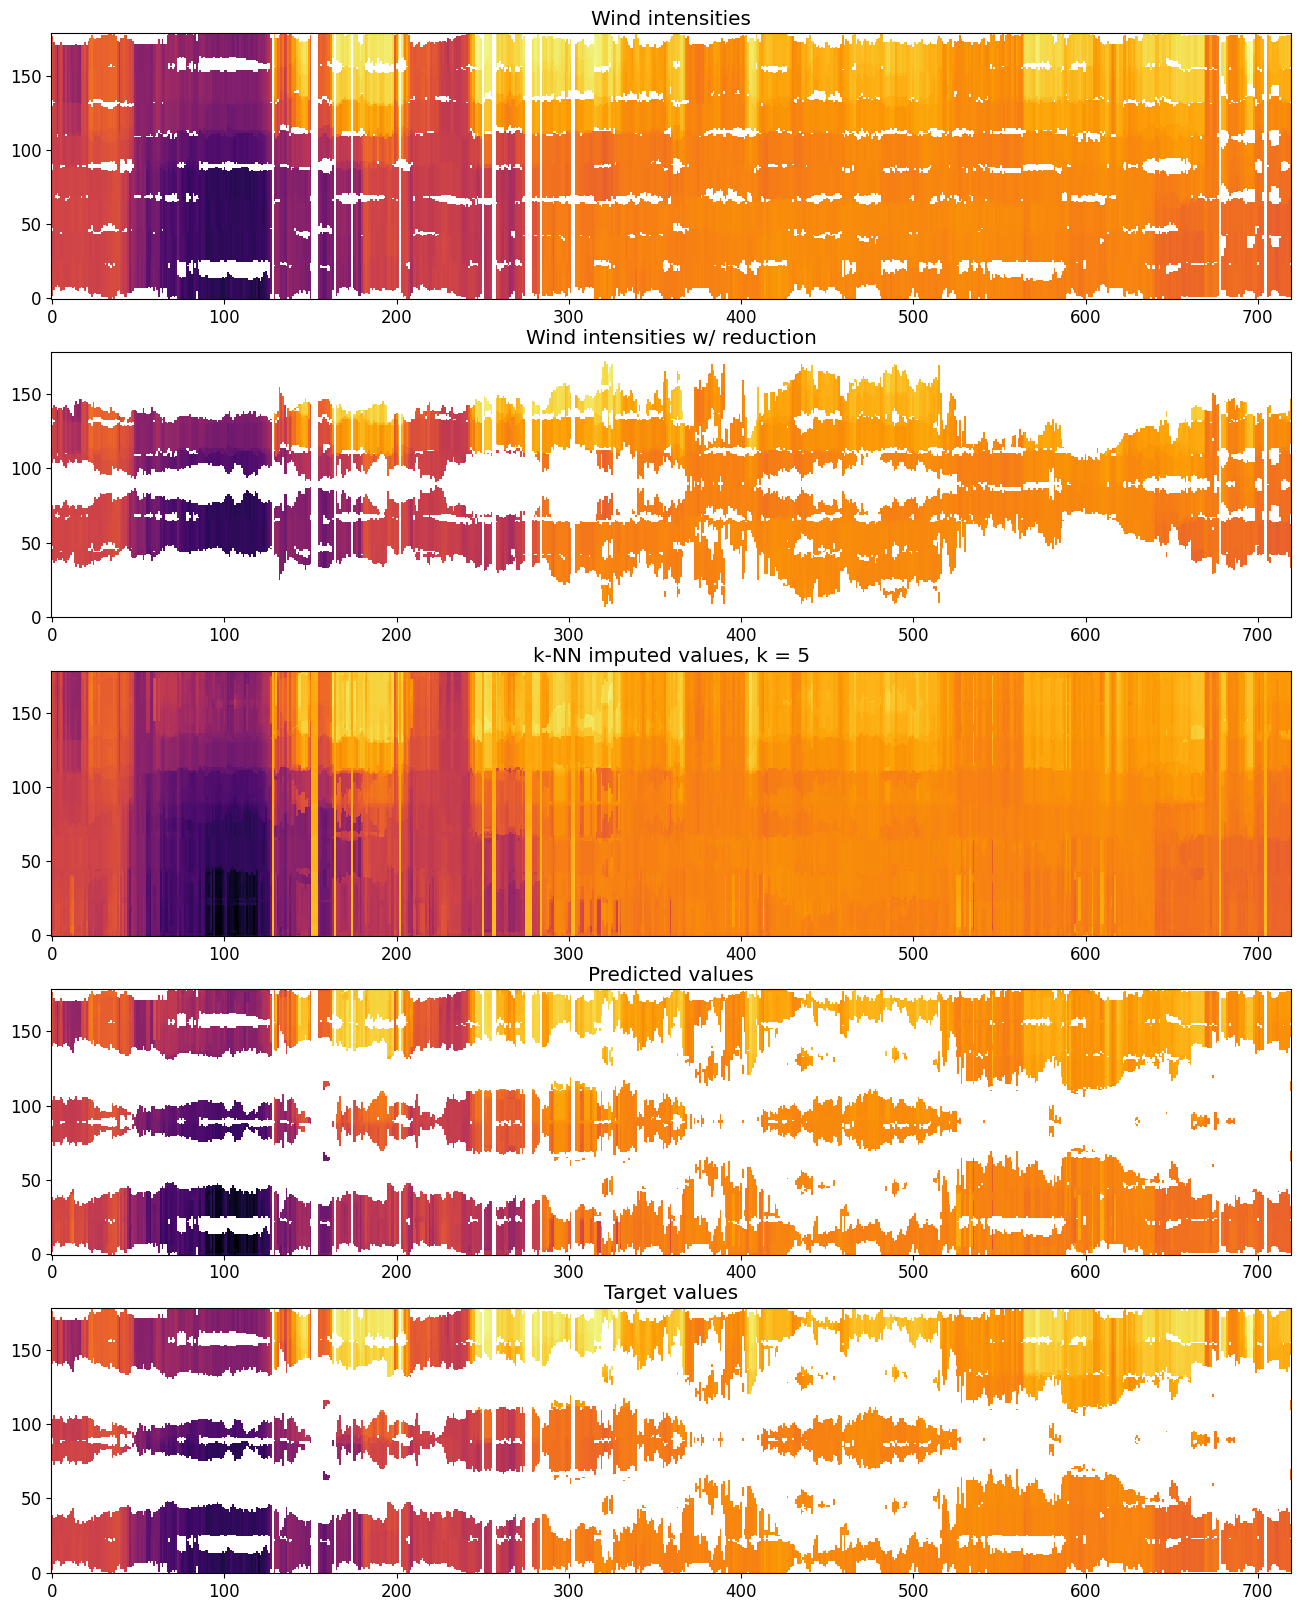

In [10]:
fig, axs = plt.subplots(nrows=5, figsize=(16,20))
hist_min = np.nanmin(np.vstack([test1, true1]))
hist_max = np.nanmax(np.vstack([test1, true1]))
axs[0].pcolormesh(X2, Y2, true1, norm=LogNorm(hist_min, hist_max), cmap="inferno")
axs[0].set_title("Wind intensities")
axs[1].pcolormesh(X2, Y2, reduced, norm=LogNorm(hist_min, hist_max), cmap="inferno")
axs[1].set_title("Wind intensities w/ reduction")
axs[2].pcolormesh(X2, Y2, test1, norm=LogNorm(hist_min, hist_max), cmap="inferno")
axs[2].set_title(f"k-NN imputed values, k = {5}")
axs[3].pcolormesh(X2, Y2, pred, norm=LogNorm(hist_min, hist_max), cmap="inferno")
axs[3].set_title("Predicted values")
axs[4].pcolormesh(X2, Y2, target, norm=LogNorm(hist_min, hist_max), cmap="inferno")
axs[4].set_title("Target values")

In [11]:
target = target.flatten()
pred = pred.flatten()
r2_score(target[np.isfinite(target)], pred[np.isfinite(pred)])

0.8617637149592168

In [ ]:
np.isclose(target[np.isfinite(target)], pred[np.isfinite(pred)])

array([ True,  True,  True, ...,  True,  True,  True], shape=(49491,))

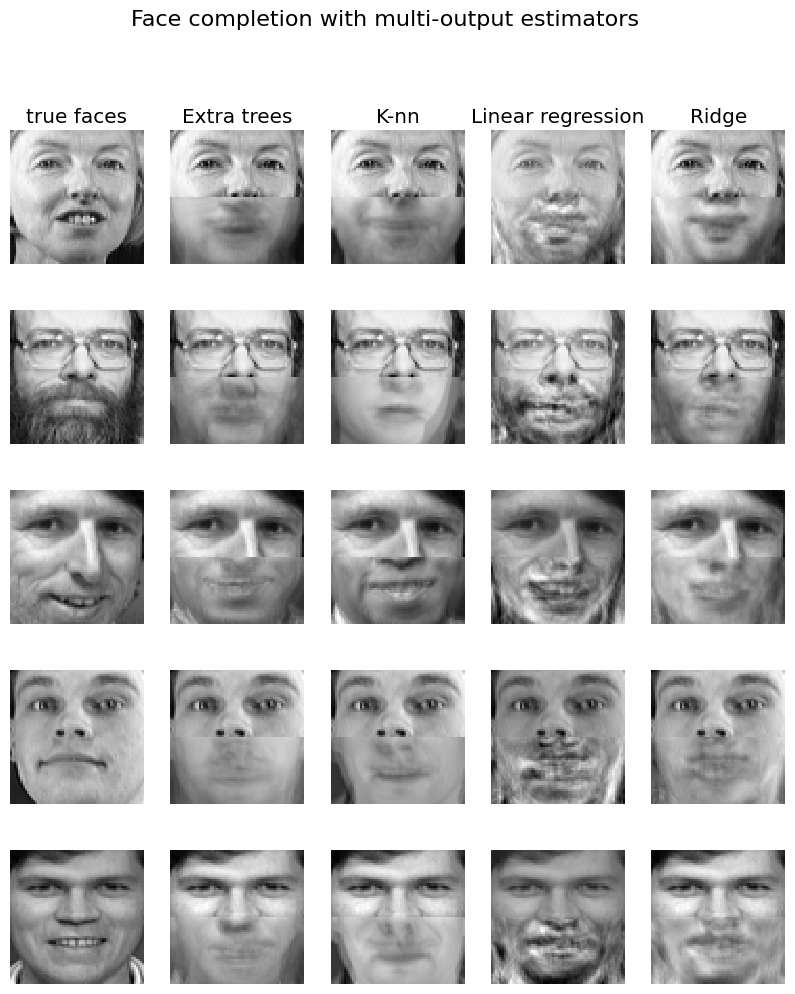

In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils.validation import check_random_state

# Load the faces datasets
data, targets = fetch_olivetti_faces(return_X_y=True)

train = data[targets < 30]
test = data[targets >= 30]  # Test on independent people

# Test on a subset of people
n_faces = 5
rng = check_random_state(None)
face_ids = rng.randint(test.shape[0], size=(n_faces,))
test = test[face_ids, :]

n_pixels = data.shape[1]
# Upper half of the faces
X_train = train[:, : (n_pixels + 1) // 2]
# Lower half of the faces
y_train = train[:, n_pixels // 2 :]
X_test = test[:, : (n_pixels + 1) // 2]
y_test = test[:, n_pixels // 2 :]

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=10, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
}

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(X_train, y_train)
    y_test_predict[name] = estimator.predict(X_test)

# Plot the completed faces
image_shape = (64, 64)

n_cols = 1 + len(ESTIMATORS)
plt.figure(figsize=(2.0 * n_cols, 2.26 * n_faces))
plt.suptitle("Face completion with multi-output estimators", size=16)

for i in range(n_faces):
    true_face = np.hstack((X_test[i], y_test[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1)
    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1, title="true faces")

    sub.axis("off")
    sub.imshow(
        true_face.reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest"
    )

    for j, est in enumerate(sorted(ESTIMATORS)):
        completed_face = np.hstack((X_test[i], y_test_predict[est][i]))

        if i:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j)

        else:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j, title=est)

        sub.axis("off")
        sub.imshow(
            completed_face.reshape(image_shape),
            cmap=plt.cm.gray,
            interpolation="nearest",
        )

plt.show()

In [ ]:
targets

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

In [ ]:
x = np.array([1, 2, 4, 5])

x[x>2]

array([4, 5])